## Model 1

This first model consists of a simple 3D autoencoder with 2 conv3D and 2 conv3DTranspose. Compression ratio is (2^3)^2 = 64 divided across 20 filters, that would make: 64/20 = 3.2 = CP. It's a low ratio.

In [21]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from collections import OrderedDict
from DataLoader import DataGenerator 

In [22]:
model = models.Sequential()
model.add(layers.Conv3D(10, (4, 4, 4), activation='relu', strides=2, input_shape=(12, 40, 40, 1), padding="same", data_format = "channels_last"))
model.add(layers.Conv3D(20, (4, 4, 4), strides=2, padding="same", activation='relu'))
model.add(layers.Conv3DTranspose(10, (4, 4, 4), strides=2, padding="same", activation='relu'))
model.add(layers.Conv3DTranspose(1, (4, 4, 4), strides=2, padding="same", activation = None))

In [23]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 6, 20, 20, 10)     650       
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 3, 10, 10, 20)     12820     
_________________________________________________________________
conv3d_transpose_8 (Conv3DTr (None, 6, 20, 20, 10)     12810     
_________________________________________________________________
conv3d_transpose_9 (Conv3DTr (None, 12, 40, 40, 1)     641       
Total params: 26,921
Trainable params: 26,921
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [25]:
months = 10
files = set('/lsdf/kit/scc/projects/abcde/1979/0'+str(i)+'/ERA5.pl.temperature.nc' for i in range(1,months))
z_train = xr.open_mfdataset(files, combine='by_coords')

bs=10 # batch size (from paper above)
dic = OrderedDict({'t': 1})  # Choosing first pressure level from variable temperature.
chunk_time = 12

#Define train and test datasets.
dg_train = DataGenerator(z_train.sel(time=slice('1979'), longitude=slice(6,15.75), latitude=slice(55.5,45.75)), dic, chunk_time, batch_size=bs, load=True, shuffle=True) 

Loading data into RAM


In [34]:
history = model.fit(dg_train, validation_data = dg_train, epochs=100)

Epoch 1/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0222 - val_loss: 0.0080
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0051
Epoch 3/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 4/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 5/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0078
Epoch 6/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 7/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 8/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 9/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/100
55/55 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 11/

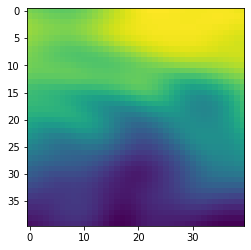

In [35]:
a = dg_train.__getitem__(8)[0]
plt.imshow(a[0,10,:,:,0])
plt.show()

In [36]:
result = model(np.expand_dims(a[0], axis=0)).numpy()

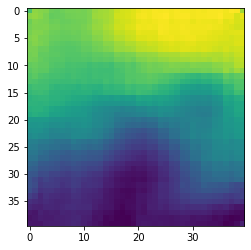

In [37]:
plt.imshow((result[0,10,:,:,0]))
plt.show()

In [38]:
test_data = z_train.sel(time=slice('1979-05-01T16:00:00','1979-05-02T03:00:00' ),level = slice(1),longitude=slice(6,15.75), latitude=slice(55.5,45.75))
test_data = test_data.transpose('time', 'latitude', 'longitude', 'level')
# Normalize
mean = test_data['t'].mean(('time', 'latitude', 'longitude')).compute()
std = test_data['t'].std('time').mean(('latitude', 'longitude')).compute() 
test_data = (test_data['t'] - mean) / std
test_data = np.expand_dims(test_data.values, axis=0)
test_data.shape

(1, 12, 40, 40, 1)

## Results

Original:

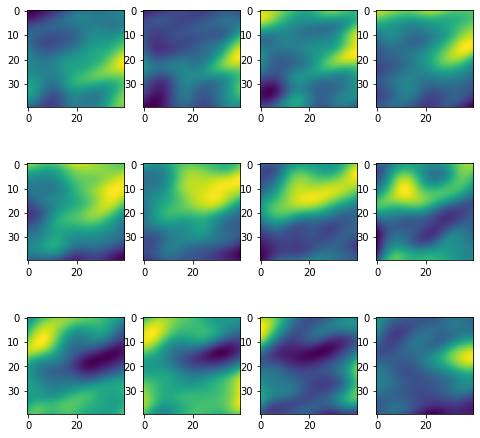

In [46]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 3
for i in range(0, columns*rows):
    img = test_data[0,i,:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()

Decompressed:

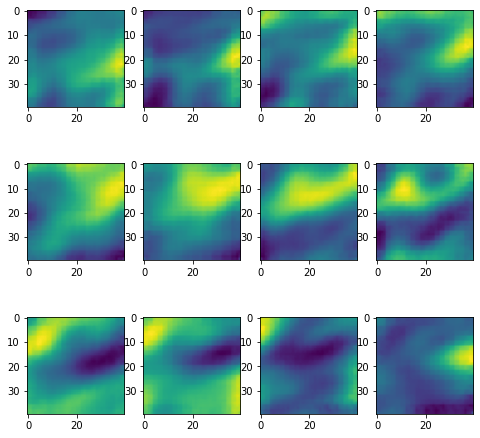

In [47]:
result2 = model(test_data).numpy()
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 3
for i in range(0, columns*rows):
    img = result2[0,i,:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
plt.show()